# Imports

In [1]:
import requests
import warnings; warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

from IPython.display import display

# Endpoints and querying

In [2]:
BASE_URL = r"https://www.balldontlie.io/api/v1"

In [4]:
TEAMS_ENDPOINT = "/".join([BASE_URL, "teams"])
PLAYERS_ENDPOINT = "/".join([BASE_URL, "players"])
STATS_ENDPOINT = "/".join([BASE_URL, "stats"])

In [5]:
all_teams_resp = requests.get(url=TEAMS_ENDPOINT)
all_teams_resp.raise_for_status()

all_teams = all_teams_resp.json().get('data')

# Jimmy Butler

In [6]:
# team_id 16: Miami Heats
player_params = {"search": "butler"}

butler_resp = requests.get(url=PLAYERS_ENDPOINT, params=player_params)
butler_resp.raise_for_status()

# Jimmy Butler ID: 79
butler = butler_resp.json()

## Kendrick Nunn (cross-check)

In [96]:
# team_id 16: Miami Heats
player_params = {"search": "nunn"}

nunn_resp = requests.get(url=PLAYERS_ENDPOINT, params=player_params)
nunn_resp.raise_for_status()

# Jimmy Butler ID: 50927
nunn = nunn_resp.json()

In [120]:
# V ----------- KENDRICK NUNN ----------- V
games_params_nunn = {
    "seasons[]": "2019",
    "player_ids[]": "50927",
    "per_page": "100",
}

nunn_stats_resp = requests.get(url=STATS_ENDPOINT, params=games_params_nunn)
nunn_stats_resp.raise_for_status()

nunn_stats = nunn_stats_resp.json().get('data')

In [7]:
# V ----------- JIMMY BUTLER ----------- V
games_params = {
    "seasons[]": "2019",
    "player_ids[]": "79",
    "per_page": "100",
}

stats_resp = requests.get(url=STATS_ENDPOINT, params=games_params)
stats_resp.raise_for_status()

butler_stats = stats_resp.json().get('data')

## Preprocessing

In [165]:
df1 = pd.DataFrame.from_dict(nunn_stats)

df1[['mins_played', 'secs_played']] = df1['min'].str.split(":", expand=True)

df1['mins_played']= pd.to_numeric(df1['mins_played'])
df1['secs_played'] = pd.to_numeric(df1['secs_played'])

mins_played_thrsh = 5
ndf1 = df1.loc[df1['mins_played'] >= mins_played_thrsh]

ndf1.rename(columns=COLS_DICT, inplace=True)

ndf1['new_score'] = ndf1.apply(lambda r: grade_performance(r), axis=1)
ndf1['weighted_score'] = ndf1.apply(weighted_grade_performance, axis=1)

ndf1['game_winning_team'] = ndf1['game_object'].apply(get_winning_team_id)
ndf1['team_object'] = ndf1['team_object'].apply(lambda d: d['id'])
ndf1['own_team_won'] = ndf1.apply(lambda s: True if s['game_winning_team'] == s['team_object'] else False, axis=1)

ndf1['team_points_share'] = ndf1.apply(get_share_of_team_points, axis=1)

# as a function: points^2 / team_points (quadratic)
ndf1['weighted_points'] = ndf1.apply(lambda r: r['points'] * r['team_points_share'], axis=1)

ndf1['game_id'] = ndf1.apply(lambda r: r['game_object'].get('id'), axis=1)

In [168]:
joined_df = ndf.merge(ndf1, left_on='game_id', right_on='game_id',  
                      how='inner', suffixes=['_butler', '_nunn'])
# joined_df
# ndf1['game_id']
# ndf1.columns
joined_df['score_comparison'] = joined_df['weighted_score_butler'] / joined_df['weighted_score_nunn']
joined_df[['new_score_butler', 'new_score_nunn', 'weighted_score_butler',
           'weighted_score_nunn', 'score_comparison']]
# joined_df['weighted_score_nunn']

# TODO: should weighted_score ever be below 0, or should it have inf. at 0?

,new_score_butler,new_score_nunn,weighted_score_butler,weighted_score_nunn,score_comparison
0,0.842105,0.430556,37.426901,19.135802,1.955857
1,0.780488,0.678571,30.487805,26.506696,1.150193
2,0.682432,0.571429,30.602351,25.624600,1.194257
3,0.608333,0.284483,29.106858,13.611615,2.138384
4,0.875000,0.240000,39.062500,10.714286,3.645833
5,0.833333,0.401786,36.710720,17.699811,2.074074
6,0.833333,0.652174,34.293553,26.838433,1.277778
7,0.993243,-0.029412,46.413236,-1.374382,-33.770270
8,1.092857,0.462121,53.835327,22.764592,2.364871
9,0.655172,0.531250,33.089516,26.830808,1.233266


In [179]:
# Butler performs better than Nunn in 88% of last season's games (accd. to our performance metric)
len(joined_df.loc[abs(joined_df['score_comparison']) > 1]) / len(joined_df)

0.8823529411764706

In [8]:
df = pd.DataFrame.from_dict(butler_stats)

df.columns

Index(['id', 'ast', 'blk', 'dreb', 'fg3_pct', 'fg3a', 'fg3m', 'fg_pct', 'fga',
       'fgm', 'ft_pct', 'fta', 'ftm', 'game', 'min', 'oreb', 'pf', 'player',
       'pts', 'reb', 'stl', 'team', 'turnover'],
      dtype='object')

In [9]:
df['min']

0     38:57
1     41:43
2     37:09
3     30:40
4     32:26
      ...  
56     0:00
57    38:05
58    41:34
59    36:38
60    34:18
Name: min, Length: 61, dtype: object

In [10]:
df[['mins_played', 'secs_played']] = df['min'].str.split(":", expand=True)

df['mins_played']= pd.to_numeric(df['mins_played'])
df['secs_played'] = pd.to_numeric(df['secs_played'])

df[['mins_played', 'secs_played']]

,mins_played,secs_played
0,38.0,57.0
1,41.0,43.0
2,37.0,9.0
3,30.0,40.0
4,32.0,26.0
...,...,...
56,0.0,0.0
57,38.0,5.0
58,41.0,34.0
59,36.0,38.0


In [12]:
mins_played_thrsh = 5
ndf = df.loc[df['mins_played'] >= mins_played_thrsh]

In [13]:
ndf.columns

Index(['id', 'ast', 'blk', 'dreb', 'fg3_pct', 'fg3a', 'fg3m', 'fg_pct', 'fga',
       'fgm', 'ft_pct', 'fta', 'ftm', 'game', 'min', 'oreb', 'pf', 'player',
       'pts', 'reb', 'stl', 'team', 'turnover', 'mins_played', 'secs_played'],
      dtype='object')

In [14]:
COLS_DICT = {
    "ast": "assists",
    "blk": "blocks",
    "dreb": "defensive_rebounds",
    "fg3_pct": "3pt_percentage",
    "fg3a": "3pt_attempts",
    "fg3m": "3pt_made",
    "fg_pct": "2pt_percentage",
    "fga": "2pt_attempts",
    "fgm": "2pt_made",
    "ft_pct": "1pt_percentage",
    "fta": "1pt_attempts",
    "ftm": "1pt_made",
    "game": "game_object",
    "oreb": "offensive_rebounds",
    "pf": "personal_fouls",
    "player": "player_object",
    "pts": "points",
    "reb": "rebounds",
    "stl": "steals",
    "team": "team_object",
    "turnover": "turnovers",
}

ndf.rename(columns=COLS_DICT, inplace=True)

In [15]:
ndf.columns

Index(['id', 'assists', 'blocks', 'defensive_rebounds', '3pt_percentage',
       '3pt_attempts', '3pt_made', '2pt_percentage', '2pt_attempts',
       '2pt_made', '1pt_percentage', '1pt_attempts', '1pt_made', 'game_object',
       'min', 'offensive_rebounds', 'personal_fouls', 'player_object',
       'points', 'rebounds', 'steals', 'team_object', 'turnovers',
       'mins_played', 'secs_played'],
      dtype='object')

In [16]:
assert ndf.offensive_rebounds.sum() + ndf.defensive_rebounds.sum() == ndf.rebounds.sum(), \
    "Should be total"

In [17]:
ndf.describe()

,id,assists,blocks,defensive_rebounds,3pt_percentage,3pt_attempts,3pt_made,2pt_percentage,2pt_attempts,2pt_made,...,1pt_attempts,1pt_made,offensive_rebounds,personal_fouls,points,rebounds,steals,turnovers,mins_played,secs_played
count,5.400000e+01,54.00000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,1.820683e+06,6.12963,0.537037,4.814815,18.270370,2.166667,0.537037,45.737037,13.388889,6.074074,...,9.074074,7.555556,1.796296,1.370370,20.240741,6.611111,1.703704,2.185185,33.796296,28.944444
std,2.328471e+05,3.08402,0.840327,2.894850,30.306613,1.969101,1.022630,14.696082,4.159176,2.732418,...,4.273004,3.800033,1.264607,0.977025,7.009253,3.049384,1.326502,1.505638,4.279744,18.595411
min,1.486916e+06,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,18.800000,3.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,24.000000,1.000000
25%,1.639884e+06,4.00000,0.000000,3.000000,0.000000,1.000000,0.000000,35.875000,11.000000,4.000000,...,6.000000,5.000000,1.000000,1.000000,16.000000,5.000000,1.000000,1.000000,32.000000,10.500000
50%,1.785912e+06,6.50000,0.000000,4.000000,0.000000,2.000000,0.000000,45.250000,14.000000,6.000000,...,8.500000,8.000000,2.000000,1.000000,20.000000,6.000000,2.000000,2.000000,34.000000,26.500000
75%,1.928328e+06,8.00000,1.000000,6.000000,33.300000,3.000000,1.000000,55.775000,16.000000,7.750000,...,12.000000,10.000000,3.000000,2.000000,24.750000,8.000000,2.000000,3.000000,36.000000,44.000000
max,2.241757e+06,13.00000,4.000000,16.000000,100.000000,10.000000,6.000000,83.300000,22.000000,14.000000,...,21.000000,17.000000,5.000000,4.000000,38.000000,18.000000,6.000000,6.000000,44.000000,58.000000


In [18]:
# object_cols = [s for s in COLS_DICT.values() if s.endswith("_object")]

# for col in object_cols:
#     ndf[col] = ndf[col].apply(lambda x: x.get("id"))

## Correlation analysis

In [19]:
corr = ndf[[c for c in ndf.columns if not c.endswith("_object")]].corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)
corr
# sns.set(rc={'figure.figsize': (20, 15)})
# sns.heatmap(corr, xticklabels=ndf.columns, yticklabels=ndf.columns, annot=True);

,id,assists,blocks,defensive_rebounds,3pt_percentage,3pt_attempts,3pt_made,2pt_percentage,2pt_attempts,2pt_made,...,1pt_attempts,1pt_made,offensive_rebounds,personal_fouls,points,rebounds,steals,turnovers,mins_played,secs_played
id,1.000000,-0.102334,-0.029616,0.127780,-0.303624,-0.557476,-0.356266,0.134134,-0.045430,0.072516,...,-0.104259,-0.080900,-0.126077,0.032882,-0.028732,0.061456,-0.316821,-0.263040,-0.150177,0.007512
assists,-0.102334,1.000000,0.194495,0.307012,0.108306,-0.007323,0.128965,-0.169180,-0.211181,-0.209468,...,-0.043005,-0.099798,0.075820,-0.201883,-0.200415,0.233968,0.020914,0.100456,0.258296,0.228589
blocks,-0.029616,0.194495,1.000000,0.075944,-0.026197,-0.005494,0.027124,-0.033673,-0.018207,-0.051590,...,-0.048196,-0.021856,-0.142669,0.176260,-0.019223,-0.011319,-0.056397,0.157067,0.034006,-0.096655
defensive_rebounds,0.127780,0.307012,0.075944,1.000000,0.013331,-0.020621,0.060396,0.008526,0.190968,0.186823,...,-0.096540,-0.115335,-0.077346,-0.098414,0.143677,0.869788,-0.016105,0.028781,0.146308,0.126753
3pt_percentage,-0.303624,0.108306,-0.026197,0.013331,1.000000,0.384018,0.967421,0.213068,0.143572,0.152951,...,0.040955,-0.010151,0.086181,-0.006118,0.202888,-0.016445,0.100947,0.128712,0.042238,0.211237
3pt_attempts,-0.557476,-0.007323,-0.005494,-0.020621,0.384018,1.000000,0.494291,-0.232516,0.491705,0.178439,...,0.090035,0.068431,0.139326,0.096898,0.235067,0.042698,0.157899,0.150381,0.330509,-0.218708
3pt_made,-0.356266,0.128965,0.027124,0.060396,0.967421,0.494291,1.000000,0.167134,0.235978,0.202593,...,0.054646,0.000735,0.125133,0.050696,0.251519,0.047072,0.084373,0.135811,0.079336,0.120033
2pt_percentage,0.134134,-0.169180,-0.033673,0.008526,0.213068,-0.232516,0.167134,1.000000,-0.005960,0.615737,...,-0.142921,-0.094182,-0.314057,0.036669,0.421076,-0.165873,-0.023680,-0.086224,-0.091915,0.060113
2pt_attempts,-0.045430,-0.211181,-0.018207,0.190968,0.143572,0.491705,0.235978,-0.005960,1.000000,0.725744,...,0.111966,0.116042,0.120447,0.194197,0.626699,0.246344,-0.076808,-0.182784,0.420891,-0.270471
2pt_made,0.072516,-0.209468,-0.051590,0.186823,0.152951,0.178439,0.202593,0.615737,0.725744,1.000000,...,-0.000251,0.018325,-0.093126,0.176748,0.760237,0.115164,-0.096042,-0.170571,0.339084,-0.177484


In [20]:
for c in corr.columns:
    display(corr[c].loc[abs(corr[c]) >= .3])

id                1.000000
3pt_percentage   -0.303624
3pt_attempts     -0.557476
3pt_made         -0.356266
steals           -0.316821
Name: id, dtype: float64

assists               1.000000
defensive_rebounds    0.307012
Name: assists, dtype: float64

blocks    1.0
Name: blocks, dtype: float64

assists               0.307012
defensive_rebounds    1.000000
rebounds              0.869788
Name: defensive_rebounds, dtype: float64

id               -0.303624
3pt_percentage    1.000000
3pt_attempts      0.384018
3pt_made          0.967421
Name: 3pt_percentage, dtype: float64

id               -0.557476
3pt_percentage    0.384018
3pt_attempts      1.000000
3pt_made          0.494291
2pt_attempts      0.491705
mins_played       0.330509
Name: 3pt_attempts, dtype: float64

id               -0.356266
3pt_percentage    0.967421
3pt_attempts      0.494291
3pt_made          1.000000
Name: 3pt_made, dtype: float64

2pt_percentage        1.000000
2pt_made              0.615737
offensive_rebounds   -0.314057
points                0.421076
Name: 2pt_percentage, dtype: float64

3pt_attempts    0.491705
2pt_attempts    1.000000
2pt_made        0.725744
points          0.626699
mins_played     0.420891
Name: 2pt_attempts, dtype: float64

2pt_percentage    0.615737
2pt_attempts      0.725744
2pt_made          1.000000
points            0.760237
mins_played       0.339084
Name: 2pt_made, dtype: float64

1pt_percentage    1.000000
1pt_made          0.453473
points            0.314310
Name: 1pt_percentage, dtype: float64

1pt_attempts    1.000000
1pt_made        0.947831
points          0.586523
Name: 1pt_attempts, dtype: float64

1pt_percentage    0.453473
1pt_attempts      0.947831
1pt_made          1.000000
personal_fouls    0.305575
points            0.616458
Name: 1pt_made, dtype: float64

2pt_percentage       -0.314057
offensive_rebounds    1.000000
rebounds              0.369036
Name: offensive_rebounds, dtype: float64

1pt_made          0.305575
personal_fouls    1.000000
points            0.311741
Name: personal_fouls, dtype: float64

2pt_percentage    0.421076
2pt_attempts      0.626699
2pt_made          0.760237
1pt_percentage    0.314310
1pt_attempts      0.586523
1pt_made          0.616458
personal_fouls    0.311741
points            1.000000
mins_played       0.387113
Name: points, dtype: float64

defensive_rebounds    0.869788
offensive_rebounds    0.369036
rebounds              1.000000
Name: rebounds, dtype: float64

id       -0.316821
steals    1.000000
Name: steals, dtype: float64

turnovers    1.0
Name: turnovers, dtype: float64

3pt_attempts    0.330509
2pt_attempts    0.420891
2pt_made        0.339084
points          0.387113
mins_played     1.000000
Name: mins_played, dtype: float64

secs_played    1.0
Name: secs_played, dtype: float64

In [21]:
tpt_df = ndf[['id', 'steals']].copy()
tpt_df.set_index("id", inplace=True)
tpt_df.sort_index(inplace=True)
tpt_df

,steals
id,
1486916,3
1496928,6
1510405,4
1519859,2
1529165,0
1535350,2
1551434,2
1560925,3
1571339,3


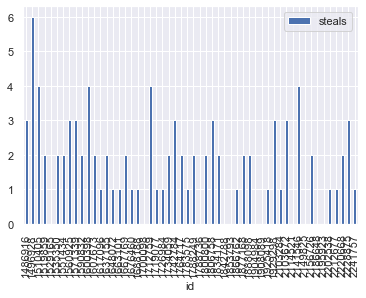

In [22]:
tpt_df.plot.bar(y='steals');

In [23]:
ndf.columns

Index(['id', 'assists', 'blocks', 'defensive_rebounds', '3pt_percentage',
       '3pt_attempts', '3pt_made', '2pt_percentage', '2pt_attempts',
       '2pt_made', '1pt_percentage', '1pt_attempts', '1pt_made', 'game_object',
       'min', 'offensive_rebounds', 'personal_fouls', 'player_object',
       'points', 'rebounds', 'steals', 'team_object', 'turnovers',
       'mins_played', 'secs_played'],
      dtype='object')

## Performance grading

In [24]:
numeric_cols = ["assists", "blocks", "rebounds", "points", "steals", "turnovers", "personal_fouls"]

DEF_WEIGHT = 1
PERF_WEIGHTS = {
    "points": 1,
    "turnovers": -2,
    "personal_fouls": -.25,
    "assists": 1.5,
    "steals": 3,
    "blocks": 2,
}

def grade_performance(row):
    game_obj = row['game_object']
    score = 0
    for col in numeric_cols:
        score += row[col] * PERF_WEIGHTS.get(col, DEF_WEIGHT)
    return score / row['mins_played']

In [25]:
ndf['new_score'] = ndf.apply(lambda r: grade_performance(r), axis=1)

ndf[numeric_cols + ['mins_played', 'new_score']].sort_values(by="new_score", ascending=False, inplace=True)
ndf

,id,assists,blocks,defensive_rebounds,3pt_percentage,3pt_attempts,3pt_made,2pt_percentage,2pt_attempts,2pt_made,...,personal_fouls,player_object,points,rebounds,steals,team_object,turnovers,mins_played,secs_played,new_score
0,1551434,13,0,3,0.0,2,0,46.2,13,6,...,0,"{'id': 79, 'first_name': 'Jimmy', 'height_feet...",20,3,2,"{'id': 16, 'abbreviation': 'MIA', 'city': 'Mia...",0,38.0,57.0,0.842105
1,1700098,10,0,16,33.3,3,1,42.1,19,8,...,0,"{'id': 79, 'first_name': 'Jimmy', 'height_feet...",20,18,0,"{'id': 16, 'abbreviation': 'MIA', 'city': 'Mia...",3,41.0,43.0,0.780488
2,1712759,3,0,3,0.0,5,0,45.0,20,9,...,1,"{'id': 79, 'first_name': 'Jimmy', 'height_feet...",23,3,4,"{'id': 16, 'abbreviation': 'MIA', 'city': 'Mia...",2,37.0,9.0,0.682432
3,1486916,2,0,1,50.0,2,1,45.5,11,5,...,1,"{'id': 79, 'first_name': 'Jimmy', 'height_feet...",21,5,3,"{'id': 16, 'abbreviation': 'MIA', 'city': 'Mia...",4,30.0,40.0,0.608333
4,1590832,5,4,4,50.0,4,2,18.8,16,3,...,2,"{'id': 79, 'first_name': 'Jimmy', 'height_feet...",21,5,2,"{'id': 16, 'abbreviation': 'MIA', 'city': 'Mia...",3,32.0,26.0,0.875000
6,1637155,6,0,4,0.0,2,0,27.3,11,3,...,2,"{'id': 79, 'first_name': 'Jimmy', 'height_feet...",16,5,2,"{'id': 16, 'abbreviation': 'MIA', 'city': 'Mia...",1,27.0,46.0,0.833333
7,1742784,8,1,4,100.0,1,1,66.7,3,2,...,0,"{'id': 79, 'first_name': 'Jimmy', 'height_feet...",9,5,3,"{'id': 16, 'abbreviation': 'MIA', 'city': 'Mia...",3,27.0,53.0,0.833333
8,2228875,6,0,6,0.0,0,0,47.1,17,8,...,1,"{'id': 79, 'first_name': 'Jimmy', 'height_feet...",28,8,3,"{'id': 16, 'abbreviation': 'MIA', 'city': 'Mia...",0,37.0,20.0,0.993243
9,1496928,11,3,8,0.0,2,0,20.0,10,2,...,1,"{'id': 79, 'first_name': 'Jimmy', 'height_feet...",5,9,6,"{'id': 16, 'abbreviation': 'MIA', 'city': 'Mia...",4,35.0,10.0,1.092857
10,1519859,4,0,3,0.0,3,0,25.0,12,3,...,0,"{'id': 79, 'first_name': 'Jimmy', 'height_feet...",16,7,2,"{'id': 16, 'abbreviation': 'MIA', 'city': 'Mia...",3,29.0,18.0,0.655172


In [77]:
def weighted_grade_performance(row):
    unweighted_score = grade_performance(row)
    game_obj = row['game_object']
    total_game_points = game_obj['home_team_score'] + game_obj['visitor_team_score']
    return unweighted_score / total_game_points * 10e3

In [78]:
ndf['weighted_score'] = ndf.apply(weighted_grade_performance, axis=1)

In [26]:
ndf['team_object'] = ndf['team_object'].apply(lambda d: d['id'])

In [27]:
# {'id': 62731,
#  'date': '2019-11-12T00:00:00.000Z',
#  'home_team_id': 16,
#  'home_team_score': 117,
#  'period': 4,
#  'postseason': False,
#  'season': 2019,
#  'status': 'Final',
#  'time': '     ',
#  'visitor_team_id': 9,
#  'visitor_team_score': 108}

def get_winning_team_id(game):
    return game['home_team_id'] if game['home_team_score'] > game['visitor_team_score'] \
        else game['visitor_team_id']

In [28]:
ndf['game_winning_team'] = ndf['game_object'].apply(get_winning_team_id)
ndf['own_team_won'] = ndf.apply(lambda s: True if s['game_winning_team'] == s['team_object'] else False, axis=1)

In [29]:
ndf.groupby('own_team_won').agg({'id': 'count', 'points': 'mean', 'new_score': ['min', 'mean', 'max']})

id     points new_score                    
             count       mean       min      mean       max
own_team_won                                               
False           18  22.055556  0.401515  0.681133  0.993243
True            36  19.333333  0.218750  0.742876  1.351852

### Weighting points per game

In [30]:
# {'id': 62731,
#  'date': '2019-11-12T00:00:00.000Z',
#  'home_team_id': 16,
#  'home_team_score': 117,
#  'period': 4,
#  'postseason': False,
#  'season': 2019,
#  'status': 'Final',
#  'time': '     ',
#  'visitor_team_id': 9,
#  'visitor_team_score': 108}

def get_share_of_team_points(row):
    game_obj = row['game_object']
    team = 'home_team' if row['team_object'] == game_obj.get('home_team_id') else 'visitor_team'
    return row['points'] / game_obj['_'.join([team, "score"])]

In [31]:
ndf['team_points_share'] = ndf.apply(get_share_of_team_points, axis=1)
ndf['team_points_share']

0     0.170940
1     0.148148
2     0.209091
3     0.187500
4     0.169355
6     0.131148
7     0.069767
8     0.269231
9     0.047170
10    0.179775
11    0.139535
12    0.179487
13    0.225225
15    0.142857
16    0.137931
17    0.103448
18    0.274194
19    0.206349
20    0.129630
21    0.146789
22    0.183486
23    0.397849
25    0.209091
26    0.129630
28    0.250000
29    0.186916
30    0.176991
31    0.090000
33    0.179104
34    0.292035
35    0.277372
36    0.095238
37    0.270588
38    0.156863
39    0.099099
40    0.114754
41    0.206612
42    0.113208
44    0.170940
45    0.168142
46    0.198020
47    0.235294
48    0.185841
49    0.247525
50    0.232759
51    0.127907
52    0.181818
53    0.221311
54    0.137097
55    0.171429
57    0.275000
58    0.213675
59    0.257143
60    0.121739
Name: team_points_share, dtype: float64

In [32]:
# as a function: points^2 / team_points (quadratic)
ndf['weighted_points'] = ndf.apply(lambda r: r['points'] * r['team_points_share'], axis=1)

In [33]:
ndf[['game_object', 'own_team_won', 'points', 'team_points_share', 'weighted_points']].sort_values(by='weighted_points', ascending=False).iloc[0].game_object

{'id': 62893,
 'date': '2019-12-04T00:00:00.000Z',
 'home_team_id': 2,
 'home_team_score': 112,
 'period': 4,
 'postseason': False,
 'season': 2019,
 'status': 'Final',
 'time': '     ',
 'visitor_team_id': 16,
 'visitor_team_score': 93}

In [36]:
ndf.groupby('own_team_won').agg({
    'id': 'count', 'points': 'mean', 'weighted_points': 'mean', 'team_points_share': ['mean', 'max'],
})

id     points weighted_points team_points_share          
             count       mean            mean              mean       max
own_team_won                                                             
False           18  22.055556        5.170562          0.214603  0.397849
True            36  19.333333        3.569491          0.166089  0.277372